## Intrusion Classification of IoT Network using Ensemble Tree Models

### <font color = 'black'> 1. Project Objective </font>

The primary objective of this project is to use ensemble tree-based models to classify intrusion types within network traffic data. This will be achieved by leveraging the predictive power of ensemble methods, specifically focusing on Random Forest and Gradient Boosting Machine, to build a robust classification model. 

The model will be trained on a labeled dataset of network traffic features, where each data sample is associated with a specific adversarial network behaviour (e.g., SSH attack, DDOS attack, etc.) or labelled as normal traffic (e.g. MQTT). 

The model evaluation will be performed using Grid Search Cross-validation technique. 

The performance of the developed model will be rigorously assessed using appropriate evaluation metrics (e.g. F1 score, accuracy, recall), to determine its effectiveness in identifying and categorizing various network traffic.  

The ultimate goal is to create a reliable and efficient traffic classification system that can effectively distinguish between different attack types and normal behaviors, thereby contributing to enhanced network security. 

### <font color = 'black'> 2. Datasets </font>

### <font color = 'black'> 2.1 Introduction of Data and Source </font>

The dataset used in this project is RT-IoT-2022 obtained from <font color = 'blue'> UCI ML data repository </font> recommended in project instruction.  

The RT-IoT-2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios. Incorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can leverage the RT-IoT2022 dataset to advance the capabilities of Intrusion Detection Systems (IDS), fostering the development of robust and adaptive security solutions for real-time IoT networks. 

The link to the data is : https://archive.ics.uci.edu/dataset/942/rt-iot2022

### <font color = 'black'> 2.2 Data Exploration and Preprocessing </font>

In [26]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [59]:
from joblib import dump, load

#### <font color = 'black'> 2.2.1 Dataset Description </font>

##### <font color = 'blue'> Remove the Limit on the number of rows displayed </font>

In [3]:
pd.options.display.max_rows = None

##### <font color = 'blue'> Load Data (Data not provided due to large file size; It can be obtained from https://archive.ics.uci.edu/dataset/942/rt-iot2022  </font>

In [4]:
df = pd.read_csv('RT_IOT2022.csv')

In [5]:
df.head()

,Unnamed: 0,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish


In [6]:
df.dtypes

Unnamed: 0                    int64
id.orig_p                     int64
id.resp_p                     int64
proto                        object
service                      object
flow_duration               float64
fwd_pkts_tot                  int64
bwd_pkts_tot                  int64
fwd_data_pkts_tot             int64
bwd_data_pkts_tot             int64
fwd_pkts_per_sec            float64
bwd_pkts_per_sec            float64
flow_pkts_per_sec           float64
down_up_ratio               float64
fwd_header_size_tot           int64
fwd_header_size_min           int64
fwd_header_size_max           int64
bwd_header_size_tot           int64
bwd_header_size_min           int64
bwd_header_size_max           int64
flow_FIN_flag_count           int64
flow_SYN_flag_count           int64
flow_RST_flag_count           int64
fwd_PSH_flag_count            int64
bwd_PSH_flag_count            int64
flow_ACK_flag_count           int64
fwd_URG_flag_count            int64
bwd_URG_flag_count          

In [7]:
pd.value_counts(df.dtypes)

float64    56
int64      26
object      3
Name: count, dtype: int64

In [8]:
df.shape

(123117, 85)

In [9]:
pd.unique(df['Attack_type']).shape

(12,)

The description of data overview is given in below table: 
|Item|Value|
|:---|:---:|
|number of features| 84|
|number of data samples | 123117 |
|number of numeric features | 81 |
|number of categorical features | 2 |
|number of IoT Traffic Types | 12 |


The description of some key features and label
| variable name | role | type | missing value |
|:---|:---|:---|:---:|
|id.orig_p| feature | Integer|No|
|id.resp_p| feature | Integer|No|
|proto| feature | Categorical|No|
|service| feature | Categorical|No|
|flow_duration| feature | Float|No|
|fwd_pkts_tot| feature | Integer|No|
|...| ... | ...|No|
|fwd_last_window_size| feature | Integer|No|
|Attack_type| Target | Categorical|No|

#### <font color = 'black'> 2.2.2 Data Cleaning </font>

##### <font color = 'blue'> 2.2.2.1 Identify the rows that contain missing or NA data </font>

In [10]:
df[df.isna().any(axis = 1)]

,Unnamed: 0,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type


##### <font color = 'blue'> 2.2.2.2 The above shows 0 rows that contain missing or N/A data. No missing or N/A data in the dataset </font>

##### <font color = 'blue'> The first column is just index column. Not a feature, let's drop it </font>

In [11]:
df = df.drop(columns = ['Unnamed: 0'], axis = 1)

In [12]:
df.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish


##### <font color = 'blue'> 2.2.2.3 Traffic Class Distribution Plot to understand label distribution </font>

In [15]:
traffic_type_counts = pd.value_counts(df.iloc[:,-1])

Text(0, 0.5, 'Number of Occurences')

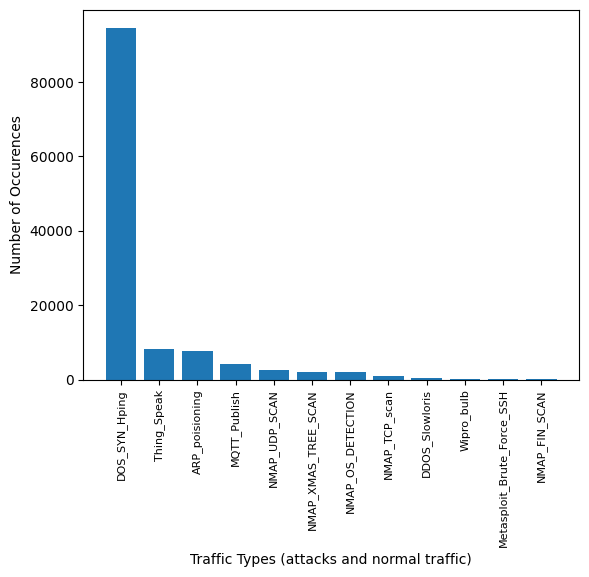

In [18]:
plt.bar(traffic_type_counts.index, traffic_type_counts)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Traffic Types (attacks and normal traffic)')
plt.ylabel('Number of Occurences')

##### <font color = 'blue'> 2.2.2.4 Discussion on Label Imbalance </font>

The above shows the IoT traffic types that include both normal and intrusion traffic flows. The data types are imbalanced. The below classification methods are sensitive to the data type imbalance.
   * logistic regression
   * SVM
   * KNN
   * deep learning with softmax layers for multiclass classification

However, the ensemble tree based models are not data imbalance sensitive and are suitable for this project. The methods we will evalaute are:
* Gradient boosting: The boosting algorithm focuses on misclassified data samples, so it can reduce data imbalance impact.
* Random Forest: It benefits from diversity of base tree estimators

##### <font color = 'blue'> 2.2.2.5 Conclusion on Data Cleaning</font>
* The IoT traffic data provided by UCI repository is quite clean, with no missing values detected. We dropped only an index column and retained the remaining features and target label columns.
* We will use ensemble tree based classifiers to avoid the impact of imbalanced data 


#### <font color = 'black'> 2.2.3 EDA </font>

##### <font color = 'blue'> 2.2.3.1 Normalization </font>
This is for Correlation Analysis only. We will use Ensemble tree models, therefore, data normalization is not critical for a tree-based model. However, for the proper interpretation of correlation coefficients, we need to normalize them. As the feature values are all positive, we can simply use min max normalization

In [24]:
scaler = MinMaxScaler()
## correlation matrix is only for numeric features. we remove categorical features and label
df_normalized = df.drop(columns = ['proto', 'service', 'Attack_type'], axis = 1)
column_names = df_normalized.columns
df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized), columns = column_names)

In [25]:
df_normalized.head()

,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,0.590021,0.028797,0.001473,0.002071,0.000494,0.00069,0.000297,2.681236e-07,1.489573e-07,2.085404e-07,...,0.005217,0.0,0.099097,0.099097,0.001418,0.099097,0.0,0.98024,0.409659,0.00766
1,0.780392,0.028797,0.001467,0.002071,0.000494,0.00069,0.000297,2.692003e-07,1.495562e-07,2.093778e-07,...,0.004636,0.0,0.099518,0.099518,0.001424,0.099518,0.0,0.98024,0.409659,0.00766
2,0.683009,0.028797,0.001478,0.002071,0.000494,0.00069,0.000297,2.671852e-07,1.484365e-07,2.078109e-07,...,0.005216,0.0,0.099474,0.099474,0.001423,0.099474,0.0,0.98024,0.409659,0.00766
3,0.929168,0.028797,0.001471,0.002071,0.000494,0.00069,0.000297,2.685480e-07,1.491928e-07,2.088704e-07,...,0.004680,0.0,0.099713,0.099713,0.001427,0.099713,0.0,0.98024,0.409659,0.00766
4,0.779538,0.028797,0.001468,0.002071,0.000494,0.00069,0.000297,2.690420e-07,1.494675e-07,2.092547e-07,...,0.004772,0.0,0.099382,0.099382,0.001422,0.099382,0.0,0.98024,0.409659,0.00766


##### <font color = 'blue'> 2.2.3.2 Correlation Matrix </font>

In [27]:
corr_features = df_normalized.corr()

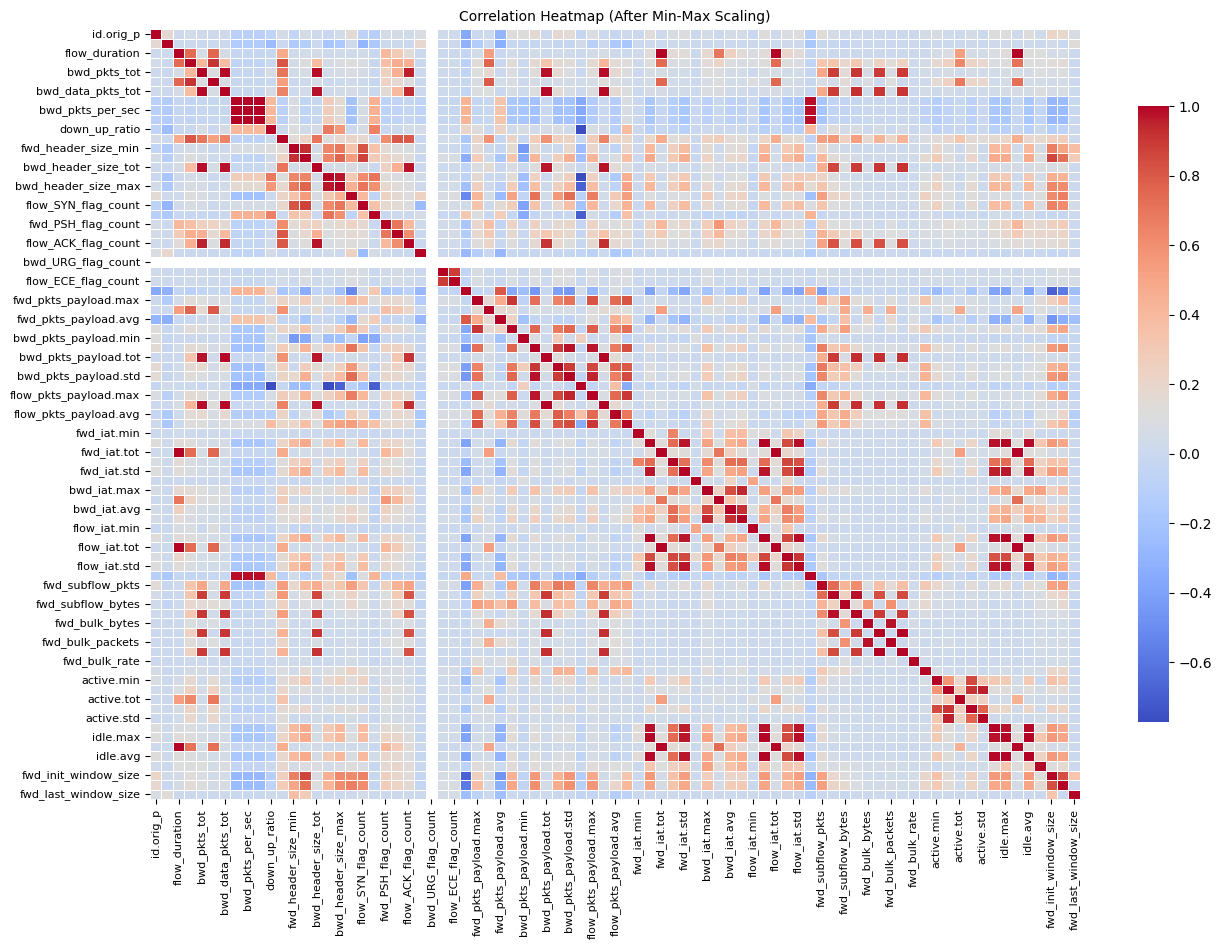

In [46]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_features, cmap='coolwarm', annot=False, fmt=".2f", 
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap (After Min-Max Scaling)", fontsize=10)
plt.xticks(fontsize=8, rotation=90)  # X-axis: font size 10, rotated vertically
plt.yticks(fontsize=8, rotation=0) 
#plt.tight_layout()
plt.show()

##### <font color = 'blue'> 2.2.3.3 EDA Conclusion </font>
* The correlation matrix of all numeric features has shown that some features have strong correlations
* The bar plot of the target labels has shown storng imbalance among the traffic types

##### <font color = 'blue'> The correlation and imbalanced target labels indicate the preferred model for this multiclass classification problem will be a tree-based model </font>

We will use Ensembled tree-based models with cross-validated hyper parameter search to evaluate the traffic attack classification

### <font color = 'black'> 3. Build Preprocessing Pipeline </font>

### 3.1 Machine Learning Model Selection

As mentioned above, we will use tree-based models. For the robustness, we will focus on two ensembled tree-based models: Gradient Boosting Machine, and Random Forest Model. 

The model selection is based on the following observations:

* <font color = 'blue'> Data normalization not necessary </font> for ensemble tree-based models: ensemble tree-based models (e.g., Random Forest, Gradient Boosting) don't require normalization. These models are based on decision trees, which are not sensitive to feature scaling because they split data based on feature thresholds (e.g., > or < conditions) rather than relying on distances or gradients. Thus, it is not necessary to normalize the data, as it won't harm the performance of the model, and can even save time and computation.
  
* <font color = 'blue'> Data imbalance mitigation </font>: The Gradient Boost and Random Forest can mitigate the imbalanced data. Firstly, the Gradient Boost algorithm trains subsequent models on the misclassified instances from previous models. Secondly, Trees split based on class distributions, so they may still learn about the minority class even if it's underrepresented

* <font color = 'blue'> Correlated features mitigation </font>: Ensembled tree-based models split the data based on feature thresholds. This means they focus on identifying the most important features for splitting at each node in the tree. If two features are highly correlated, decision trees may still prefer one over the other for splitting, often choosing the feature that gives the best split according to a criterion (like Gini Impurity or Information Gain). Thus, the feature correlation can be effetively mitigated by ensembled tree-based models.


### 3.2 Categorical Features Onehot Encoding

The two categorical features 'proto' and 'service' will need One Hot Encoder to convert binary encoded values

In [47]:
onehot_features = ['proto',	'service']
Col_transform = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = True), onehot_features)
    ], remainder = 'passthrough'
)


### 3.3 Build Preprocessing Pipeline

In [48]:
pipe = Pipeline([
    ('preprocess', Col_transform),
    ('classifier', GradientBoostingClassifier())
])

### 3.4 Split Data to Train Test Datasets
We will split data into Pandas df format. The DataFrame will be used as input

In [49]:
features = df.iloc[:,0:-1]

In [50]:
target = df.iloc[:,-1]

In [51]:
fea_train, fea_test, tgt_train, tgt_test = train_test_split(features, target, test_size = 0.2, random_state = 55)

### 3.5 Apply Label Encoder to the Target Label

In [52]:
tgt_train = tgt_train.to_numpy()
tgt_test = tgt_test.to_numpy()

In [53]:
tgt_encoder = LabelEncoder()

In [54]:
y_train = tgt_encoder.fit_transform(tgt_train)

In [55]:
y_test = tgt_encoder.transform(tgt_test)

In [56]:
y_train.shape

(98493,)

In [57]:
pd.unique(y_train).shape

(12,)

In [15]:
pd.unique(y_test).shape

(12,)

### 4. Model Training -- Cross Validation Grid Search
* We will use GridSearchCV for Two Different Classifiers

### 4.1 Create GridSearchCV Parameter Grids

* We will use two classifiers: GradientBoostingClassifier() and RandomForestClassifier()

* We will investigate two major hypter parameters for the ensembled tree-based models: number of base estimators, and the maximum depth of the base estimator tree

In [76]:
para_grid = [
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_depth': [1, 3, 5, 10]
    #    'classifier__min_samples_leaf':[1, 8]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_depth': [1, 3, 5, 10]
  #      'classifier__min_samples_leaf':[1, 8]
    }
]

### 4.2 Determine the Validation Metrics and Create GridSearchCV Instance

* The data is imbalanced, therefore we will macro F1 Score to effectively evaluate the performance of the model predicting all 12 network traffic classes.
  
* <font color = 'blue'> The Macro F1 Score </font> (or 'f1_macro') means that we're calculating the F1 score for each class individually and then taking the unweighted average. This is very useful when we have <font color = 'blue'> imbalanced classes </font> and want to ensure that each class is treated equally, rather than giving more weight to the majority class.

In [77]:
grid_search = GridSearchCV(pipe, para_grid, cv=5, scoring = 'f1_macro', verbose=1, n_jobs = -1)

In [78]:
import time

In [79]:
time0 = time.time()

### 4.3 Run Cross-Validation Grid Search to Train Models and Find the Optimal Hyperparameters

* *** Alert *** The below cross validation grid search will take about 4 hours to complete due to the large dataset size.

In [20]:
grid_search.fit(fea_train, y_train)
print(time.time() - time0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
15968.382016658783


Let's save the results. The above CV Search took more than 15,000 s (more than 4 hrs) in a 12 core CPU virtual machine

so we definitely want to save the results

In [81]:
dump(grid_search, 'grid_search_results.joblib')

['grid_search_results.joblib']

In [82]:
grid_search_load = load('grid_search_results.joblib')

### 4.4 Find the Best Estimator and Evaluate the Model Performance on Test Dataset

* It has identified that the best estimator is RandomForestClassifier with max base tree depth of 10, and 100 base estimators

In [61]:
grid_search_load.best_params_

{'classifier': RandomForestClassifier(max_depth=10),
 'classifier__max_depth': 10,
 'classifier__n_estimators': 100}

In [62]:
df_cv = pd.DataFrame(grid_search_load.cv_results_)

In [63]:
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,698.295028,7.468633,1.772508,0.045927,GradientBoostingClassifier(),1,50,"{'classifier': GradientBoostingClassifier(), '...",0.764364,0.749686,0.768279,0.773012,0.848116,0.780691,0.034604,15
1,1389.762034,13.226231,3.177987,0.058866,GradientBoostingClassifier(),1,100,"{'classifier': GradientBoostingClassifier(), '...",0.838092,0.837605,0.844331,0.859164,0.923445,0.860527,0.032409,14
2,2078.855115,21.137280,4.860128,0.202099,GradientBoostingClassifier(),1,150,"{'classifier': GradientBoostingClassifier(), '...",0.838301,0.838683,0.844549,0.859261,0.923644,0.860887,0.032284,13
3,1819.523920,16.785621,3.271581,0.110945,GradientBoostingClassifier(),3,50,"{'classifier': GradientBoostingClassifier(), '...",0.936821,0.960748,0.925663,0.971821,0.969329,0.952876,0.018384,8
4,3630.994124,43.267258,6.117053,0.088808,GradientBoostingClassifier(),3,100,"{'classifier': GradientBoostingClassifier(), '...",0.944112,0.936647,0.928184,0.972398,0.957867,0.947842,0.015679,11


#### 4.4.1 Visualizing the Impact of Hyperparameters on Model Performance

* <font color = 'blue' > Gradient Boosting Classifier </font>


In [64]:
mask = df_cv['param_classifier'].apply(lambda x: isinstance(x, GradientBoostingClassifier))
df_cv_GB = df_cv[mask]

In [65]:
df_cv_RF = df_cv[~mask]

In [66]:
dict_GB = {}
for n_estim, df_group in df_cv_GB.groupby(by='param_classifier__n_estimators'):
    dict_GB[n_estim] = df_group.loc[:, ['param_classifier__max_depth', 'mean_test_score']].to_numpy()

Text(0, 0.5, 'F1 Macro Score on Validation Data')

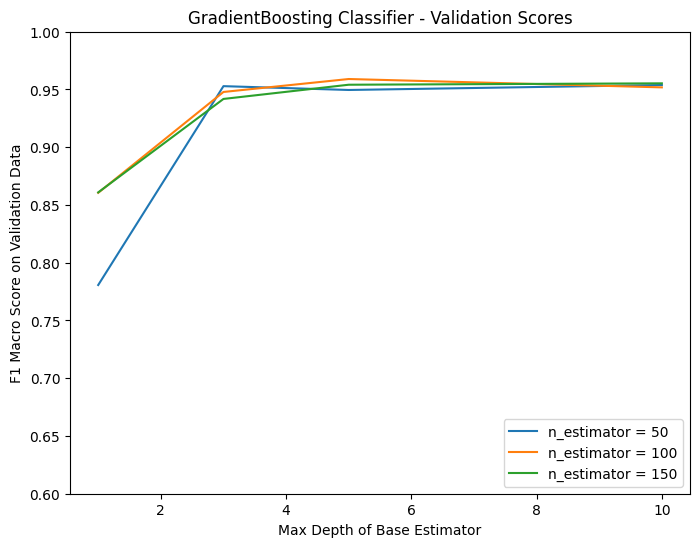

In [67]:
fig = plt.figure(figsize = (8,6))
for key, val in dict_GB.items():
    plt.plot(val[:, 0], val[:,1], label = f'n_estimator = {key}')
    plt.legend(loc = 'lower right')
plt.ylim(0.6,1)
plt.yticks(np.linspace(0.6,1,num=9))
plt.title('GradientBoosting Classifier - Validation Scores')
plt.xlabel('Max Depth of Base Estimator')
plt.ylabel('F1 Macro Score on Validation Data')

* <font color = 'blue' > Random Forest Classifier </font>

In [68]:
dict_RF = {}
for n_estim, df_group in df_cv_RF.groupby(by='param_classifier__n_estimators'):
    dict_RF[n_estim] = df_group.loc[:, ['param_classifier__max_depth', 'mean_test_score']].to_numpy()

Text(0.5, 1.0, 'RandomForest Classifier - Validation Scores')

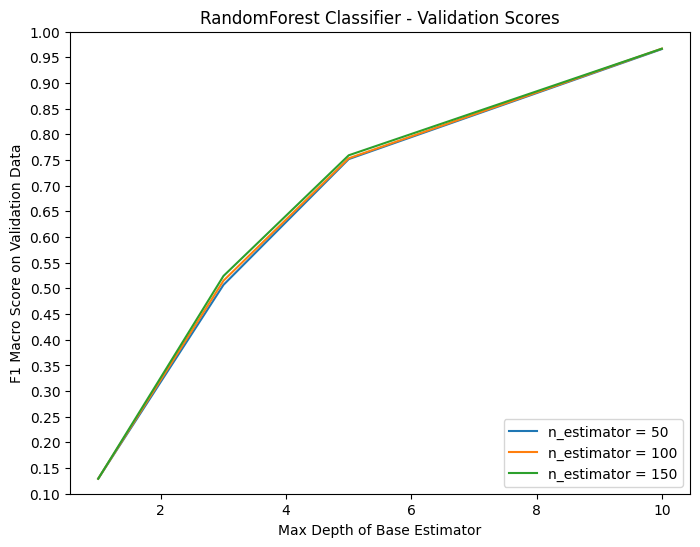

In [69]:
fig = plt.figure(figsize = (8,6))
for key, val in dict_RF.items():
    plt.plot(val[:, 0], val[:,1], label = f'n_estimator = {key}')
    plt.legend(loc = 'lower right')
plt.ylim(0.1,1)
plt.yticks(np.linspace(0.1,1,num=19))
plt.xlabel('Max Depth of Base Estimator')
plt.ylabel('F1 Macro Score on Validation Data')
plt.title('RandomForest Classifier - Validation Scores')

#### 4.4.2 Visualizing the Best Estimator Performace on Test Dataset

In [70]:
best_model = grid_search_load.best_estimator_

In [71]:
y_pred = best_model.predict(fea_test)

In [72]:
accuracy_score(y_test, y_pred)

0.9979288499025342

In [73]:
recall_score(y_test, y_pred, average = 'macro')

0.9709709538543394

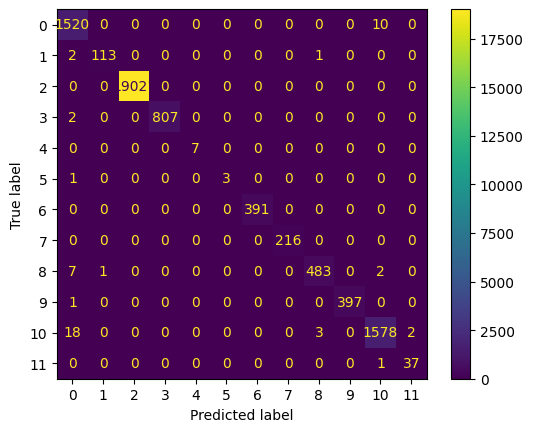

In [74]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [84]:
f1_score(y_test, y_pred, average = 'macro')

0.9799519792436843

### 5. Conclusions and Discussions

* The above confusion matrix of predicted attack types on the test data shows the Random Forest model performs quite wells on the IoT traffic classification. The macro f1 score that is averaged over each individual class is 0.979 on the test data.

* The best estimator from cross-validation grid search is Random Forest with 100 base estimators and maximum depth of 10 for the base tree. The model performace vs hyperparameter graph shows that the Random Forest's performance is not sensitive to the number of base estimators, but is highly imapcted by the maximum depth of the base tree.

* The Gradient Boosting actually has good performance on the cross validation data as well. The f1 score is around 0.95, just slighly trailing behind the Random Forest. As shown in the model performace vs hyperparameter graph, the model performance stabalizes after maximum base tree depth reaches 5, and number of base estimators reaches 100.

* Ensembled Tree-based model is very suitable for tabular multiclass classification problem. Data normalization is not necessary. The tree based model can effectively mitigate the adverse impacts of data imbalance and correlated features. 

### GitHub Repository:
gh repo command: gh repo clone WayneChK/CSCA_5622

HTTPs address: https://github.com/WayneChK/CSCA_5622.git